In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

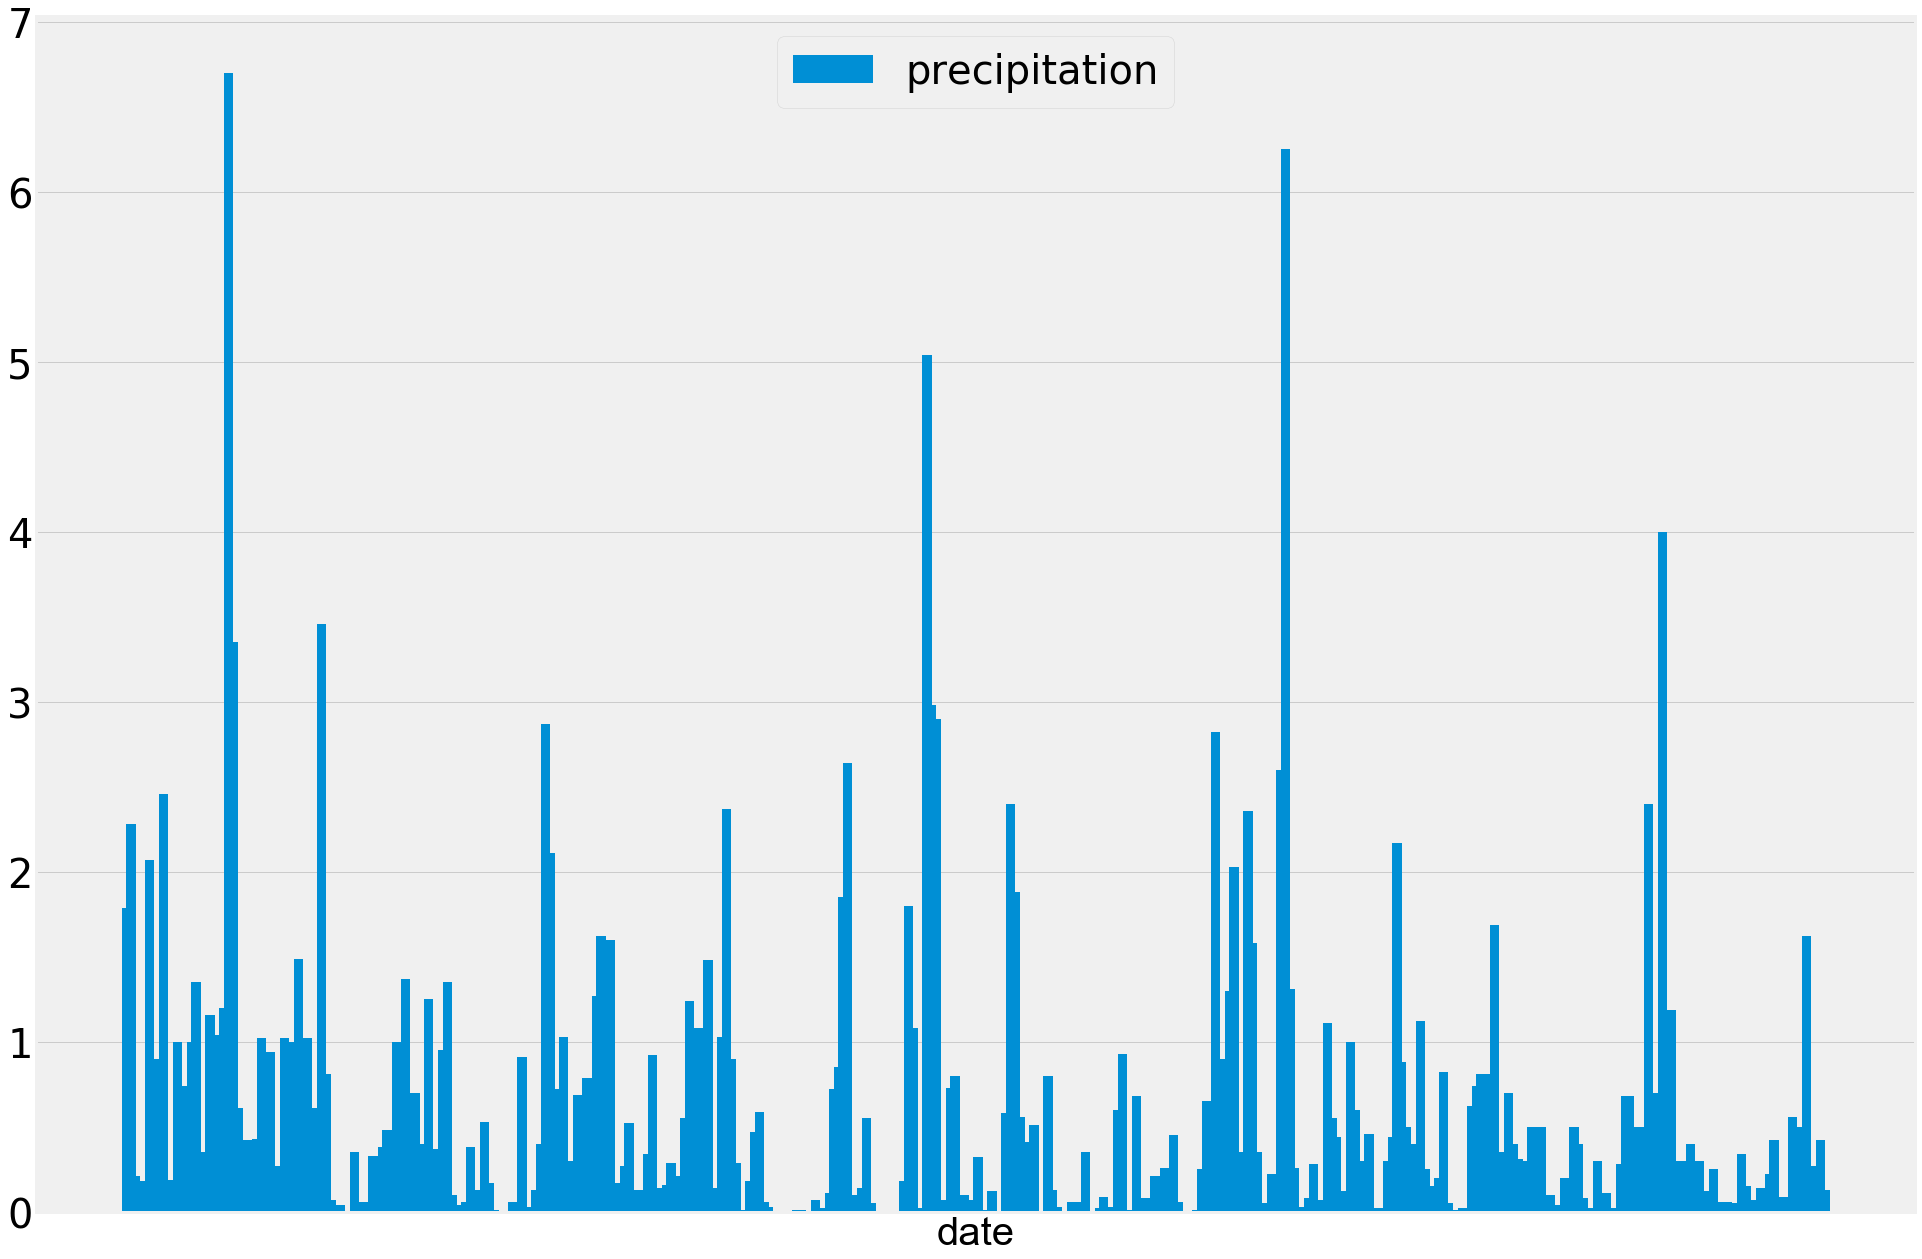

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#type(query_date_from)
#print(dt.strftime(query_date_from))
#dt.datetime.strptime(query_date_to[0][0], "YYYY-MM-DD")



#query_date_from =  func.datetime(query_date_to[0][0]) - dt.timedelta(days=365)
#type(query_date_from(all))
#print([x for x in query_date_from])
#len(session.query(Measurement.date).filter(func.strftime("%Y%m%d", Measurement.date) >= query_date_from).distinct().all())
#query_date_from[0]

#session.query(Measurement.date).order_by(Measurement.date.desc()).all()


# Calculate the date 1 year ago from the last data point in the database


query_date_to = [x for x in session.query(func.max(Measurement.date))]
datestr = str(query_date_to[0][0])

yearofdate = datestr.split('-')
yearofdate
query_date_from = dt.date(int(yearofdate[0]), int(yearofdate[1]), int(yearofdate[2]))  - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

precip12months = session.query(Measurement.date, Measurement.prcp).filter(func.strftime("%Y-%m-%d", Measurement.date) >= query_date_from ).all()


# Save the query results as a Pandas DataFrame and set the index to the date column

precip12monthsdf = pd.DataFrame(precip12months)
#precip12monthsdf.set_index('date' , inplace=True)

# Sort the dataframe by date

precip12monthsdf.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data

axis_font = {'fontname':'Arial', 'size':'40'}

plt.figure(figsize=(30,22))
plt.bar(precip12monthsdf['date'], precip12monthsdf['prcp'], label = 'precipitation', width = 2.0 , capstyle='projecting')
plt.legend(loc= "upper center", fontsize = 40)
plt.xlabel('date', **axis_font )
plt.xticks([])
plt.yticks(fontsize=40)

plt.show()
#precip12monthsdf.plot(kind='bar',figsize=(20,20))
#query_date_from

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip12monthsdf.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?

cols = [Station.id , Station.station , Station.name , Station.latitude , Station.longitude , Station.elevation]

stations = session.query(*cols).order_by(Station.station).all()

#stations

stationsdf = pd.DataFrame(stations)

stationsdf.set_index('id', inplace=True)

len(stationsdf)


9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


stationcounts = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stationcounts


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

mostactivestation = stationcounts[0][0]
cols2 = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
MaxMinAvg = session.query(*cols2).filter(Measurement.station == mostactivestation).all()
MaxMinAvg

[(54.0, 85.0, 71.66378066378067)]

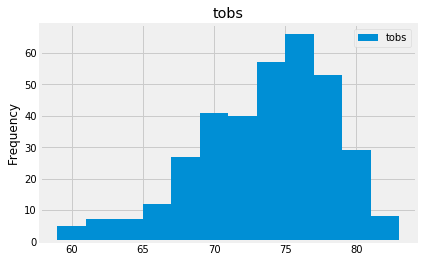

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


MostActiveStn12months = session.query(Measurement.tobs).filter(func.strftime("%Y-%m-%d", Measurement.date) >= query_date_from).filter(Measurement.station == mostactivestation).all()
MostActiveStn12monthsDf = pd.DataFrame(MostActiveStn12months)
type(MostActiveStn12monthsDf)
len(MostActiveStn12monthsDf)

MostActiveStn12monthsDf.hist(bins=12, label='tobs')


#num_bins = 12
#plt.hist(MostActiveStn12monthsDf, 12, facecolor='blue', alpha=0.5)
plt.ylabel('Frequency')
plt.legend(loc="upper right")

plt.show()


![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = '2017-01-01'
end_date = '2017-01-07'

print(calc_temps(start_date, end_date))

[(62.0, 68.36585365853658, 74.0)]


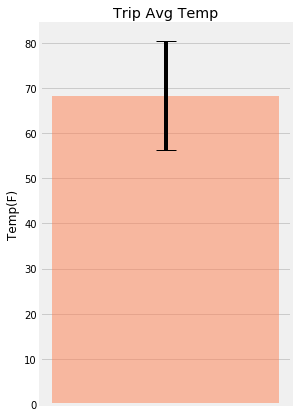

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

result = calc_temps('2017-01-01', '2017-01-07')
avg = result[0][1]
err = result[0][2] - result[0][0]
x_pos = np.arange(len(result))

#plt.bar(1,avg,yerr= err)

# Build the plot
'''fig, ax = plt.subplots()
ax.bar(x_pos ,  avg, yerr=err, align='center', alpha=0.5, width = 0.1 , color = 'coral', ecolor='black', capsize=10 )
ax.set_ylabel('Temp(F)')
ax.set_xticks(x_pos)
#ax.set_xticklabels(materials)
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
'''



plt.figure(figsize=(4,7))
plt.bar(x_pos ,  avg, yerr=err,  width =1.0 , align='center', alpha=0.5,capstyle='projecting',color = 'coral', ecolor='black', capsize=10)
plt.xticks([])
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')



# Save the figure and show
#plt.tight_layout()
plt.show()


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

totalcols = [   #Station.id ,
                Station.station ,
                Station.name ,
                Station.latitude ,
                Station.longitude ,
                Station.elevation ,
                func.sum(Measurement.prcp) 
            ]


finalresult = session.query(*totalcols).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).filter(Measurement.date <= '2017-01-07').group_by(Station.id, Station.name,Station.latitude, Station.longitude ,Station.elevation).order_by(func.sum(Measurement.prcp).desc()).all()

finalresult

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.61),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.6),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.6),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.2),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
